# Regression Analysis Problem

# Question 3 - B

# Cleyton Candeira - Data Scientist - Júnior



To assess the effectiveness of an internal corporate policy aimed at reducing pay disparities, we will initially conduct `(1st Stage)` an exploratory analysis (data visualization and statistical metrics) of the data. In detail, this analysis will focus on evaluating measures of dispersion and central tendency. If necessary, we will carry out our `(2nd Stage)` as a feature engineering process, where we will better understand the logic of the variables so that they can be simplified to create new variables. After this, we will check for normality tests `(3rd Stage)`, and then determine the types of correlations possible between the regressor variables and the target (salary).  

## 1st Stage - Importing and understanding the database

In [1]:
#Packages
import sys
import sklearn
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

print(f"Python version: {sys.version.split()[0]}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

Python version: 3.10.12
scikit-learn version: 1.3.2
Pandas version: 1.3.5
Numpy version: 1.26.1
Matplotlib version: 3.5.1
Seaborn version: 0.13.0


In [2]:
data_dir = Path('../data/1st_Phase_-_Selective_Process_-_Data_Science_-_DataBase.xlsx')

#It seems that the data typing gets messed up when the file is an .xlsx probably due to its encoding
col_type = {
    'ID': int,
    'TEMPOCASA': int,
    'IDADE': int,
}

df = pd.read_excel(data_dir, dtype=col_type)

In [3]:
df.dtypes

ID                  int64
EDUCAÇÃO           object
CARGO              object
LOCAL              object
IDADE               int64
TEMPOCASA           int64
SALARIO_MENSAL    float64
dtype: object

In [4]:
df.head(5)

,ID,EDUCAÇÃO,CARGO,LOCAL,IDADE,TEMPOCASA,SALARIO_MENSAL
0,1,SECUNDÁRIO,GERENTE,INTERIOR,30,1,4279.5
1,2,SUPERIOR,AUXILIAR,INTERIOR,32,4,4575.4
2,3,SECUNDÁRIO,AUXILIAR,CAPITAL,33,2,4735.6
3,4,SUPERIOR,GERENTE,INTERIOR,34,3,4863.1
4,5,SECUNDÁRIO,GERENTE,INTERIOR,36,1,5355.8


In [5]:
df_x = df.iloc[:, 1:].copy(deep=True) #spliting id col

In [6]:
#Accessing the first approximation: basic statistics
df_x.describe()

,IDADE,TEMPOCASA,SALARIO_MENSAL
count,80.000000,80.000000,80.000000
mean,49.750000,10.887500,5777.622500
std,9.594962,7.401665,1138.187752
min,30.000000,0.000000,4186.600000
25%,43.750000,3.750000,4894.300000
50%,49.000000,12.500000,5673.450000
75%,56.000000,17.000000,6306.300000
max,72.000000,25.000000,12465.800000


In [7]:
def plot_distribution(df: pd.DataFrame, columns: list):
    plt.style.use('ggplot')
    
    n_cols = len(columns)
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 4))

    for i, col in enumerate(columns):
        ax = axes[i] if n_cols > 1 else axes
        sns.histplot(df[col], bins=15, kde=True, ax=ax)
        mean = df[col].mean()
        median = df[col].median()
        ax.axvline(mean, color='purple', linestyle='--', label=f'Mean: {mean:.2f}')
        ax.axvline(median, color='g', linestyle='-', label=f'Median: {median:.2f}')
        ax.set_title(col)
        ax.set_xlabel('Values')
        ax.set_ylabel('Frequency')
        ax.legend()

    plt.tight_layout()
    plt.show()

In [8]:
df_numeric = df_x.select_dtypes(include=[np.number])
cols_numeric = list(df_numeric.columns)

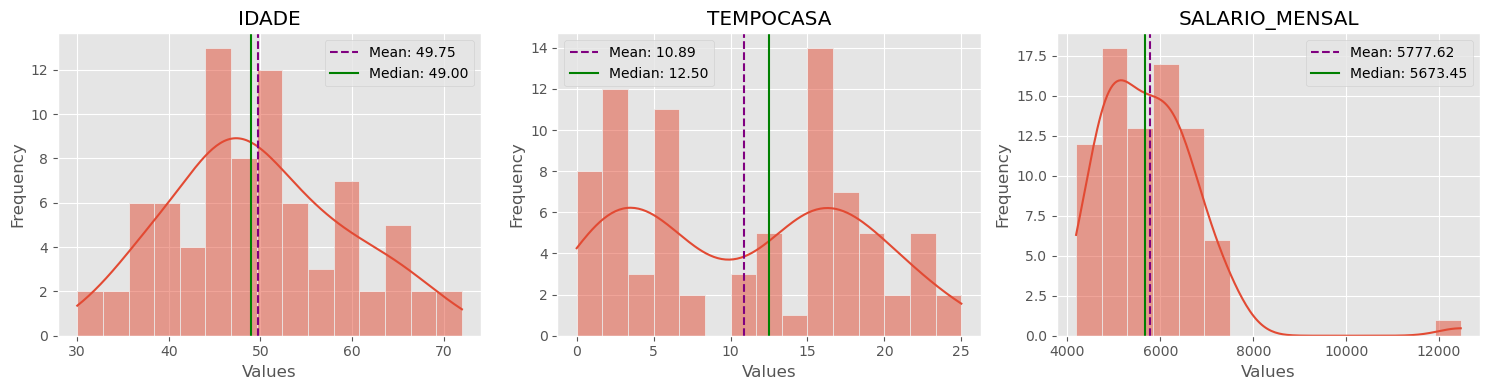

In [9]:
plot_distribution(df_numeric, cols_numeric)

The fact that the mean is significantly close to the median implies that: a) there are not a significant number of outliers that cause the median to deviate from the mean (creating bias); b) the distribution of these variables can be considered symmetrical (Gaussian). In short, `we shouldn't worry about outliers with numerical variables`. 

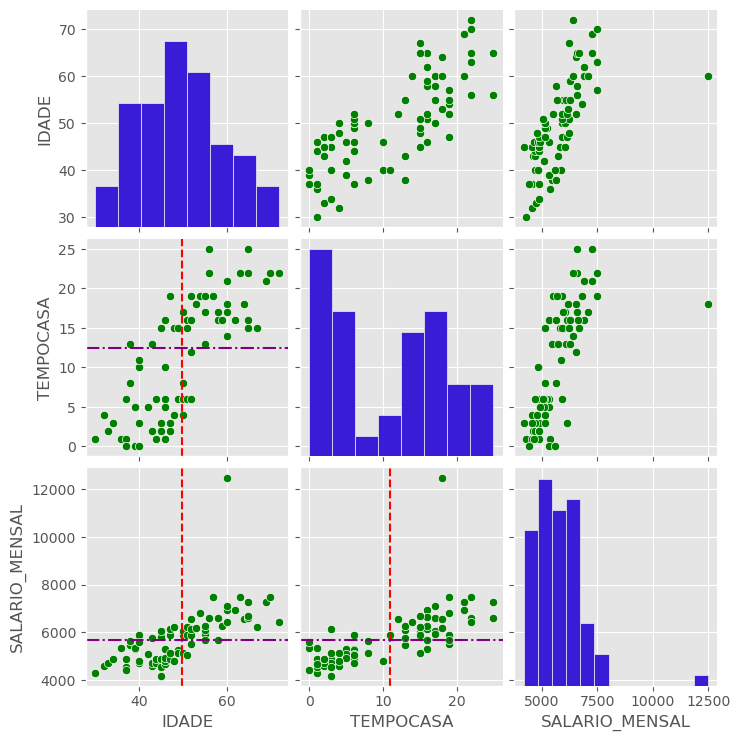

In [10]:
plt.style.use('ggplot')

g = sns.pairplot(df_x[cols_numeric])
g = g.map_offdiag(sns.scatterplot, color='green')
g = g.map_diag(sns.histplot, color='blue')

def add_mean_median_line(x, y, **kwargs):
    plt.axvline(x.mean(), color='red', linestyle='--')
    plt.axhline(y.median(), color='purple', linestyle='-.')
g.map_lower(add_mean_median_line)
plt.show()

With these results described, we can already infer some insights into the relationships between the numerical variables. 

- Generally speaking, the profile of the statistically average worker is someone who has around 10 years' experience in their job and is on average 50 years old
- The relationships are strictly centralized. Considering that there is a 60-year-old outlier who earns more than 120,000 a month and has more than 15 years' experience, this individual has no influence on the measures of central tendency
- At first glance, all the variables seem to have positive relationships. For example: the older the person, the more experience they have at work; likewise, the older the person, the higher their salary. Although there is a certain degree of statistical dispersion, definitive confirmation of these relationships will require further correlation analysis

- An interesting insight is that age is a determining factor in monthly salary. This suggests that work experience is closely associated with age, i.e., the older the employee, the more work experience they likely have

In [11]:
df_categorical = df_x.select_dtypes(include=[object])
cols_categorical = list(df_categorical.columns)

In [12]:
#It is important to note that this count already checks whether or not there are any missing values
for col in df_categorical.columns:
    print(f"Category count in the column'{col}':")
    print(df_categorical[col].value_counts())
    print("\n")

Category count in the column'EDUCAÇÃO':
SUPERIOR      65
SECUNDÁRIO    15
Name: EDUCAÇÃO, dtype: int64


Category count in the column'CARGO':
AUXILIAR    37
GERENTE     30
DIRETOR     13
Name: CARGO, dtype: int64


Category count in the column'LOCAL':
CAPITAL     45
INTERIOR    35
Name: LOCAL, dtype: int64




We can understand the relationship between the variables as follows:

- EDUCAÇÃO: There's a ordinal relationship (SUPERIOR > SECUNDÁRIO)
- CARGO: There's a ordinal relationship (DIRETOR > GERENTE > AUXILIAR)
- LOCAL: There's a nominal relationship (CAPITAL; INTERIOR)

In [13]:
ordered_cols = {
    'EDUCAÇÃO': ['SUPERIOR', 'SECUNDÁRIO'],
    'CARGO': ['DIRETOR', 'GERENTE', 'AUXILIAR'],
}

nominal_cols = ['LOCAL'] #Perhaps a fatal error would be to consider CAPITAL > INTERIOR and thus bias the entire assessment of the policy's effectiveness. 

In [14]:
for col in ordered_cols:
    df_x[col] = pd.Categorical(df_x[col], ordered=True)

df_x['LOCAL'] = pd.Categorical(df_x['LOCAL'], ordered=False)

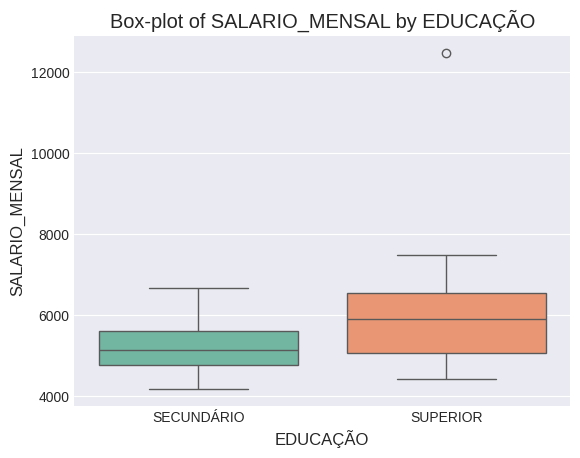

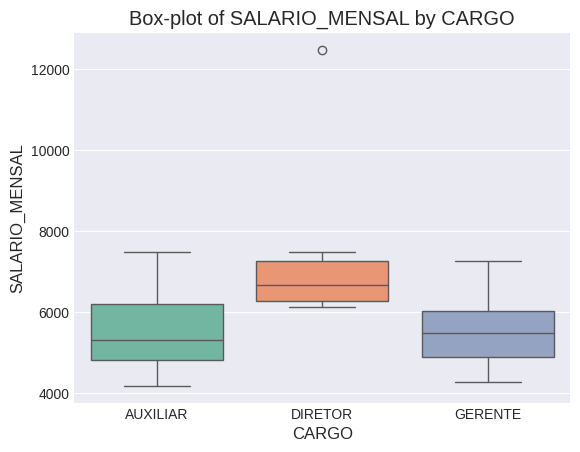

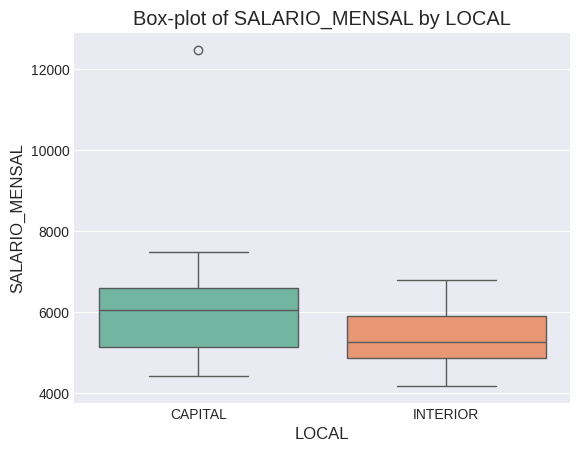

In [15]:
for col in cols_categorical:
    plt.style.use('seaborn-darkgrid')  
    sns.boxplot(x=col, y='SALARIO_MENSAL', data=df_x, hue=col, palette='Set2')    
    plt.title(f'Box-plot of SALARIO_MENSAL by {col}')
    plt.xlabel(str(col))
    plt.ylabel('SALARIO_MENSAL')
    plt.show()

- With these results described, we can already infer some insights into the database by categorical information. 
- We can say that the salary of those with a higher education is higher than those with only a secondary education; those who work in the capital earn more than those who work in the interior; those who are directors earn more than managers, and those who are managers earn more than assistants

In [16]:
df_x.isnull().sum()

EDUCAÇÃO          0
CARGO             0
LOCAL             0
IDADE             0
TEMPOCASA         0
SALARIO_MENSAL    0
dtype: int64

According to our last check, the dataframe for this case came with a huge gift: it was clean of missing values. That's a beauty! 

# 2nd Stage - Engineer Features

- Here we will deal with the `IDADE` and the `TEMPOCASA` variables 

In [17]:
#Deal with IDADE

lifestages = [
              'ADULT',  #29-39
              'MIDDLE_AGE',#39-59
              'SENIOR' #59-100
              ]
bins = [29, 39, 59, 100]

df_x['FAIXA_ETARIA'] = pd.cut(df_x['IDADE'],    
                                bins = bins, 
                               labels = lifestages)

cols_categorical.append('FAIXA_ETARIA') #Add new categorical variable

In [18]:
df_x['FAIXA_ETARIA'].isnull().sum()

0

In [19]:
print(df_x['FAIXA_ETARIA'].value_counts())

MIDDLE_AGE    53
SENIOR        15
ADULT         12
Name: FAIXA_ETARIA, dtype: int64


# 3rd Stage - Tests and Modelling

## KS-Test, Shapiro-Wilk Test, and Anderson-Darling Test

The Kolmogorov-Smirnov Test (K-S Test) is a non-parametric statistical method used to assess the relationship of a data set to a normal distribution (purely random Gaussian). It can easily be found in the scipy.stats library. Similarly, the Shapiro-Wilk test is used to measure the normality of variables, exclusively for small data samples, such as the one in this 80-line dataframe. The last test to check for normality is the Anderson-Darling test, which measures the distribution in a parametric way compared to a Gaussian function. 


In [20]:
from scipy import stats

def normality_tests(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    results = pd.DataFrame()

    for col in cols:
        # K-S Test
        ks_statistic, ks_p_value = stats.kstest(df[col], 'norm')
        ks_normal = 'True' if ks_p_value >= 0.05 else 'False'

        #Shapiro-Wilk Test
        shapiro_statistic, shapiro_p_value = stats.shapiro(df[col])
        shapiro_normal = 'True' if shapiro_p_value >= 0.05 else 'False'

        #Anderson-Darling Test
        ad_statistic, critical_values, significance_levels = stats.anderson(df[col], dist='norm')
        ad_normal = 'True' if ad_statistic < critical_values[2] else 'False'  # 5% significance level

        results = results.append({
            'Variable': col,
            'K-S Statistic': ks_statistic,
            'K-S p-value': ks_p_value,
            'K-S Normal?': ks_normal,
            'Shapiro Statistic': shapiro_statistic,
            'Shapiro p-value': shapiro_p_value,
            'Shapiro Normal?': shapiro_normal,
            'Anderson-Darling Statistic': ad_statistic,
            'Anderson-Darling Normal?': ad_normal
        }, ignore_index=True)

    return results

In [21]:
results = normality_tests(df_x, cols_numeric)

In [22]:
results

,Variable,K-S Statistic,K-S p-value,K-S Normal?,Shapiro Statistic,Shapiro p-value,Shapiro Normal?,Anderson-Darling Statistic,Anderson-Darling Normal?
0,IDADE,1.00000,0.000000e+00,False,0.983458,3.904054e-01,True,0.404573,True
1,TEMPOCASA,0.87725,2.968485e-73,False,0.920789,1.036105e-04,False,2.357736,False
2,SALARIO_MENSAL,1.00000,0.000000e+00,False,0.804820,6.502965e-09,False,1.762261,False


The result shows that the variable `IDADE` is the only one with a normal distribution (the null hypothesis cannot be rejected), while the other numerical variables, `TEMPOCASA` and `SALARIO_MENSAL`, are not close to a Gaussian distribution, requiring functional transformations for normalization.  

## chi-Squared Test for categorical variables

The chi-squared test is commonly used in statistics to check whether categorical variables have a normal distribution. There are basically two types of chi-squared tests, but the one we will use is the goodness of fit test, where the observed distribution of a categorical variable is close to a normal distribution. 

In [23]:
def chi_square_tests(df: pd.DataFrame, cols: list, expected_frequencies=None) -> pd.DataFrame:
    results = pd.DataFrame()

    for col in cols:
        observed_frequencies = df[col].value_counts()

        if expected_frequencies is None:
            exp_freq = [len(df) / len(observed_frequencies)] * len(observed_frequencies)
        else:
            exp_freq = expected_frequencies

        chi2, p_value = stats.chisquare(f_obs=observed_frequencies, f_exp=exp_freq)

        is_normal = 'True' if p_value >= 0.05 else 'False'
        
        results = results.append({
            'Variable': col,
            'Chi-Square Statistic': chi2,
            'p-value': p_value,
            'Is Normal?': is_normal
        }, ignore_index=True)

    return results

#Attention: Categorical variables will be normalized by encoding them

In [24]:
result = chi_square_tests(df_x, cols= cols_categorical)
result

,Variable,Chi-Square Statistic,p-value,Is Normal?
0,EDUCAÇÃO,31.250,2.268475e-08,False
1,CARGO,11.425,3.304401e-03,False
2,LOCAL,1.250,2.635525e-01,True
3,FAIXA_ETARIA,39.175,3.113557e-09,False


## Transform Variables

In [25]:
#Numeric Variables

def transform_numerical_variables(df: pd.DataFrame, column: str):
    transformations = {}

    # Squared
    squared_transformed = df[column] ** 2
    transformations[f'{column}_squared'] = squared_transformed

    # Log transform (just for positive values)
    if (df[column] > 0).all():
        log_transformed = np.log(df[column])
        transformations[f'{column}_log'] = log_transformed

    # Box-Cox and the best lambda
    best_lambda = None
    if (df[column] > 0).all():
        box_cox_transformed, best_lambda = stats.boxcox(df[column])
        transformations[f'{column}_box_cox'] = box_cox_transformed

    return pd.DataFrame(transformations), best_lambda

In [26]:
df_transf_dict = {}
lambda_dict = {}

for col in cols_numeric:
    try:
        df_transformed, lambda_value = transform_numerical_variables(df_x, col)
        df_transf_dict[col] = df_transformed
        lambda_dict[col] = lambda_value
    except ValueError as e:
        print(e)

In [27]:
for key, df in df_transf_dict.items():
    print(f"Normality Test for {key}:")
    transformed_cols = df.columns
    normality_results = normality_tests(df, transformed_cols)

    for index, row in normality_results.iterrows():
        print(f"  {row['Variable']}:")
        print(f"    K-S Normal? {row['K-S Normal?']}")
        print(f"    Shapiro Normal? {row['Shapiro Normal?']}")
        print(f"    Anderson-Darling Normal? {row['Anderson-Darling Normal?']}\n")

Normality Test for IDADE:
  IDADE_squared:
    K-S Normal? False
    Shapiro Normal? False
    Anderson-Darling Normal? False

  IDADE_log:
    K-S Normal? False
    Shapiro Normal? True
    Anderson-Darling Normal? True

  IDADE_box_cox:
    K-S Normal? False
    Shapiro Normal? True
    Anderson-Darling Normal? True

Normality Test for TEMPOCASA:
  TEMPOCASA_squared:
    K-S Normal? False
    Shapiro Normal? False
    Anderson-Darling Normal? False

Normality Test for SALARIO_MENSAL:
  SALARIO_MENSAL_squared:
    K-S Normal? False
    Shapiro Normal? False
    Anderson-Darling Normal? False

  SALARIO_MENSAL_log:
    K-S Normal? False
    Shapiro Normal? False
    Anderson-Darling Normal? True

  SALARIO_MENSAL_box_cox:
    K-S Normal? False
    Shapiro Normal? True
    Anderson-Darling Normal? True



The results show that the transformations that normalize the data are:

IDADE -> Log, Box-Cox

SALARIO_MENSAL -> Box-Cox

TEMPOCASA -> Does not normalize with these transformations

In [28]:
df_x['IDADE_log'] = df_transf_dict['IDADE']['IDADE_log']
df_x['SALARIO_MENSAL_box_cox'] = df_transf_dict['SALARIO_MENSAL']['SALARIO_MENSAL_box_cox'] #Target normalization is only possible if you need to deal with models such as KNN and SVM

## Standard Scale, One Hot Encoding, and Dummy variables

In [29]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

In [30]:
ordinal_cols = ['EDUCAÇÃO', 'CARGO', 'FAIXA_ETARIA']
print(nominal_cols, ordinal_cols)

['LOCAL'] ['EDUCAÇÃO', 'CARGO', 'FAIXA_ETARIA']


In [31]:
def encode_ordinal_columns(df: pd.DataFrame, columns:list):
    le = LabelEncoder()
    encoded_df = df.copy()
    
    for col in columns:
        if encoded_df[col].isnull().any():
            encoded_df[col] = encoded_df[col].fillna('') 
        encoded_df[col] = le.fit_transform(encoded_df[col])
    
    return encoded_df

In [32]:
def one_hot_encoding(df: pd.DataFrame, nominal_columns: list):

    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded_data = encoder.fit_transform(df[nominal_columns])
    encoded_cols = encoder.get_feature_names_out(nominal_columns)
    df_encoded = pd.DataFrame(encoded_data, columns=encoded_cols)
    df = df.drop(columns=nominal_columns).reset_index(drop=True)
    df_encoded = pd.concat([df, df_encoded], axis=1)

    return df_encoded


#In fact, for simplicity, 'INTERIOR' and 'CENTER' will be represented 
#as a Dummy variable where 'CENTER' is 0 (False) and 'INTERIOR' is 1 (True). 
#Therefore, using either OneHot Encoding or Label Encoding in this case would not make a difference.

In [33]:
def standard_scaling(df:pd.DataFrame, numeric_columns:list):

    scaler = StandardScaler()

    df_scaled = df.copy()
    df_scaled[numeric_columns] = scaler.fit_transform(df_scaled[numeric_columns])

    return df_scaled

In [34]:
df_x = encode_ordinal_columns(df_x, ordinal_cols)
df_x = encode_ordinal_columns(df_x, nominal_cols)
cols_numeric.pop(2) #It's not good practice to encode the target variable
df_x = standard_scaling(df_x, cols_numeric)

## Correlations

Spearman, Kendall, and Pearson are correlation coefficients used to measure the relationship between variables. Spearman is ideal for assessing monotonic relationships in ordinal data or when a non-linear relationship is suspected, as it focuses on rank orders. Kendall's Tau is also suitable for ordinal data and assesses the concordance of rankings, making it robust to outliers and non-linear relationships. Pearson is best suited for linear relationships between continuous variables, assuming a normal distribution. It's sensitive to outliers and may not capture non-linear associations effectively. The choice depends on the nature of the data and the type of relationship under investigation, with Spearman and Kendall being preferable when data is not normally distributed or non-linearity is expected.


In [35]:
def plot_correlation_map(df, columns, method='pearson'):
    if method not in ['pearson', 'kendall', 'spearman']:
        raise ValueError("O método deve ser 'pearson', 'kendall' ou 'spearman'.")

    corr_matrix = df[columns].corr(method=method)

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
    plt.title(f'Correlation Heatmap - Method {method.capitalize()}')
    plt.show()

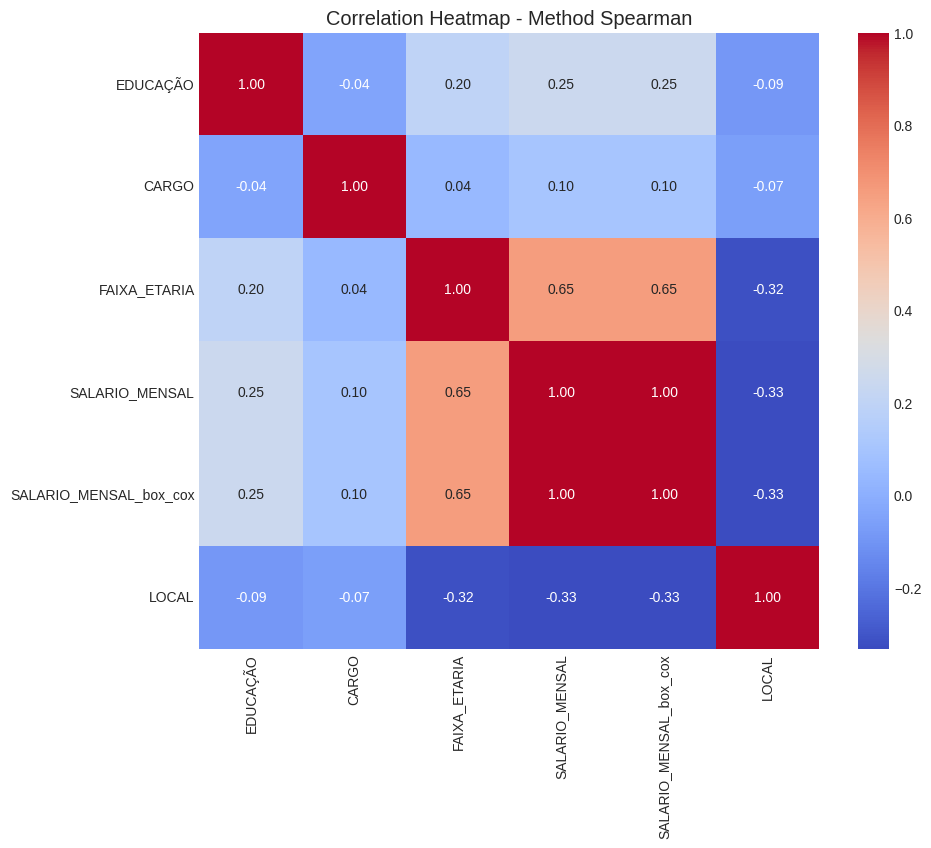

In [36]:
corr_labels = ['EDUCAÇÃO', 'CARGO', 'FAIXA_ETARIA', 'SALARIO_MENSAL', 'SALARIO_MENSAL_box_cox', 'LOCAL']
plot_correlation_map(df_x, corr_labels, method='spearman')

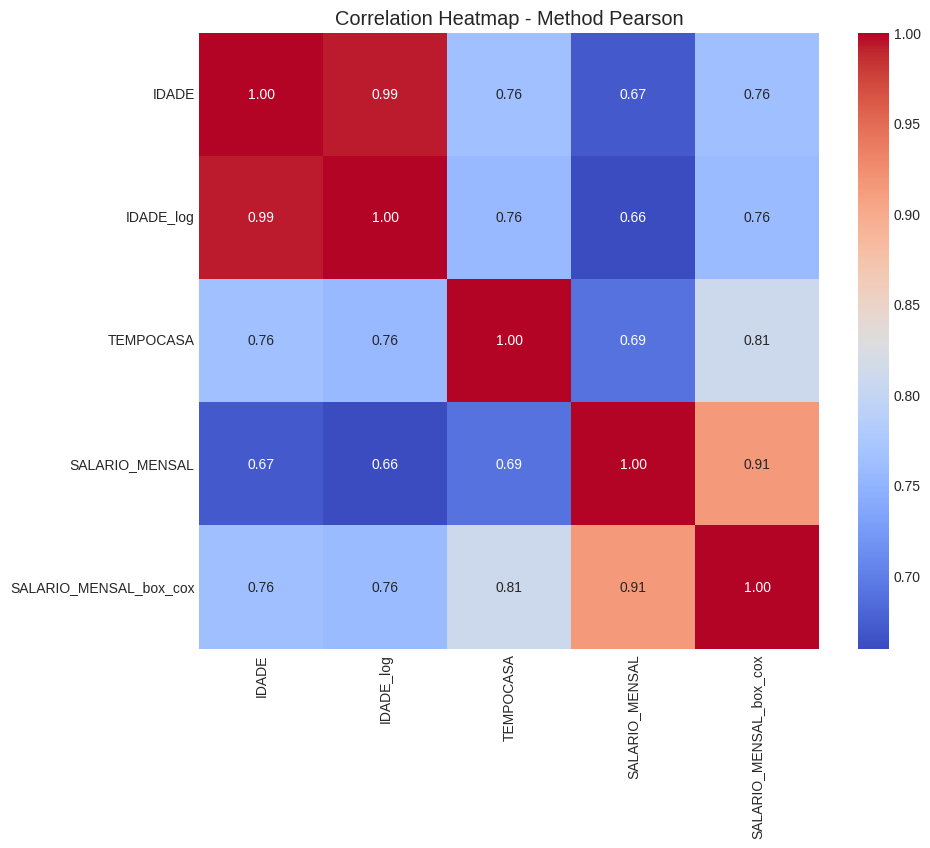

In [37]:
corr_labels = ['IDADE', 'IDADE_log', 'TEMPOCASA', 'SALARIO_MENSAL', 'SALARIO_MENSAL_box_cox']

plot_correlation_map(df_x, corr_labels, method='pearson')

Thus, the regressor variables chosen will be those that have a significant correlation, but not those that could become autocorrelated: 
- `TEMPOCASA` and `LOCAL`
- Clearly, `TEMPOCASA` and `IDADE` are correlated variables and will cause bias in the model, so they cannot together be regressors of `SALARIO_MENSAL`
- According to the literature, if other variables do not have good correlation indices, these variables probably do not contribute to explaining the `SALARIO_MENSAL`

In [38]:
df_ready = df_x[['LOCAL', 'TEMPOCASA', 'SALARIO_MENSAL']].copy(deep=True)

## Modelling

In [39]:
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro

import statsmodels.api as sm

In [40]:
X = df_ready[[
              'LOCAL', 
              'TEMPOCASA']]
y = df_ready['SALARIO_MENSAL']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Classic Econometrics - Ordinary Least Squares (OLS) Regression

In the classic econometric script, we followed these steps to estimate the model:

- Checking parameters such as R-squared, adjusted R-squared, F-statistics, and t-statistics for the estimated parameters
- Conducting a heteroscedasticity test
- Testing for the normality of residual
- Testing for autocorrelation
- Assessing multicollinearity

In [42]:
X_train_sm = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_sm).fit()

In [43]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         SALARIO_MENSAL   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     63.97
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           1.06e-15
Time:                        22:48:24   Log-Likelihood:                -483.54
No. Observations:                  64   AIC:                             973.1
Df Residuals:                      61   BIC:                             979.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5758.9653     81.835     70.373      0.0

- The R-squared value indicates that 67.7% of the variability in the target is explained by the model. Considering the adjusted R-squared, which accounts for the number of predictors, this explanation accounts for about 66.7% of the variability

- The F-statistic value is 1.06e-15, which is less than 0.05, suggesting that we can reject the null hypothesis that all the model's coefficients are equal to zero

- T-statistics for the coefficients:

    - Constant: Its t-value is -0.228, with a p-value of 0.820 (estimated p-value > 0.05), indicating that the coefficient is not statistically significant
    - LOCAL: The t-value is -0.639, with a p-value of 0.525 (estimated p-value > 0.05), also indicating that the coefficient is not statistically significant
    - TEMPOCASA: The t-value is 10.537, with a p-value of practically 0 (estimated p-value < 0.05), showing that, in contrast to the others, this coefficient is statistically significant

`Conclusion`

From this estimation, we can categorically conclude that the variability of the variable LOCAL does not significantly influence the explanation of the target SALARIO_MENSAL. This demonstrates that the internal policy aimed at reducing salary inequalities between residents of the INTERIOR and those of the CENTER has been effective. Although the descriptive statistics displayed in the Box-Plot graph indicate a slight difference in salaries, and the correlation with SALARIO_MENSAL is negative, this difference is not statistically significant according to the OLS Regression results.

### Model Evaluate

In [44]:
#Hemocedasticity Test

bp_test = het_breuschpagan(model.resid, model.model.exog)
print('Lagrange Multiplier statistic:', bp_test[0])
print('p-value:', bp_test[1])

Lagrange Multiplier statistic: 8.767753330191859
p-value: 0.012476895997867485


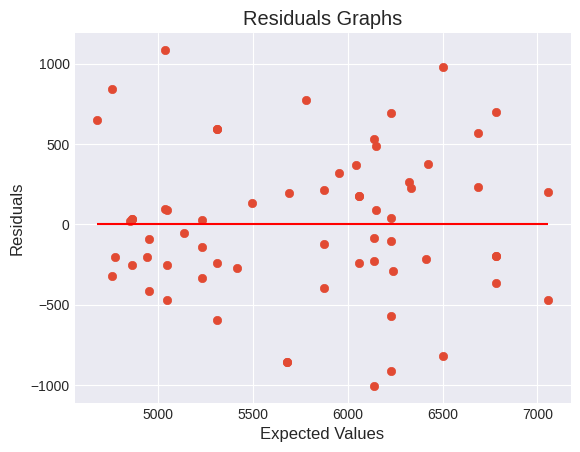

In [45]:
# Residual Graphs
predictions = model.predict(X_train_sm)

residuals = y_train - predictions

plt.scatter(predictions, residuals)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max(), colors='red')
plt.xlabel('Expected Values')
plt.ylabel('Residuals')
plt.title('Residuals Graphs')
plt.show()

Based on the results of the Breusch-Pagan test, the p-value is below 0.05, indicating that the null hypothesis of homoscedasticity can be rejected. Similarly, the graphical analysis of the residuals, showing the relative dispersion of observations without a trend, reaffirms the presence of heteroscedasticity in the model.

In [46]:
# Testing the residuals normality w/ Shapiro-Wilk
shapiro_test = shapiro(model.resid)
print('Shapiro-Wilk Test statistic:', shapiro_test[0])
print('p-value:', shapiro_test[1])

Shapiro-Wilk Test statistic: 0.9849729537963867
p-value: 0.62762850522995


In [47]:
# Testing the residuals normality w/ Jarque-Bera
jb_test = sm.stats.jarque_bera(residuals)
print('Jarque-Bera Test statistic:', jb_test[0])
print('p-value:', jb_test[1])

Jarque-Bera Test statistic: 0.2730302066310311
p-value: 0.8723931441312113


 To test the normality of the residuals, we applied the classic Shapiro-Wilk and Jarque-Bera test, which is well known in the literature. In both the Shapiro-Wilk and Jarque-Bera tests, the p-value was > 0.05, showing that there is insufficient evidence to reject the null hypothesis, i.e. there is no evidence to show that the model's residuals are not normal. 

In [48]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF Test
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
print(vif)

   VIF Factor   features
0    1.035173      LOCAL
1    1.035173  TEMPOCASA


The phenomenon of multicollinearity occurs when two or more regressors are highly correlated, which means that one variable can be linearly predicted from the others with a degree of accuracy. This phenomenon can be identified using the VIF test below, with the recommendation to exclude correlated variables. In the literature, VIF values ranging from 1 to 5 indicate the presence of multicollinearity, albeit moderate, while values between 5 and 10 suggest high multicollinearity. Values close to one, as in our case, coupled with the careful selection of previously correlated variables in the correlation map, demonstrate that there is no significant multicollinearity in the model.

In [49]:
# Autocorrelation - Durbin-Watson Test
from statsmodels.stats.stattools import durbin_watson

residuals = model.resid
dw_statistic = durbin_watson(residuals)
print('Durbin-Watson Statistic:', dw_statistic)

Durbin-Watson Statistic: 2.3107514003052834


Autocorrelation is the hypothesis that the residuals are correlated, i.e. they are not independent, expressing the possibility of non-randomness. As in the summary of the model generated, the Durbin-Watson test has a statistic of 2.31, and its range varies from 0 to 4, considering that values above 2 express negative autocorrelation and values below 2 express negative autocorrelation. 

#### Predict Model

In the experiment, sci-kit learn is commonly used for machine learning tasks, while statsmodels is used for traditional statistical inference tasks. However, with the same inputs, what differs between these two packages is the way the results are presented, although the mathematical elaboration is practically the same.

Although we have already obtained the answer with the model, one of its main purposes is to have the power to predict occurrences, and this must be tested using the test data set and its metrics verified: cross-validation, RMSE and R2-Score.


[Reference](https://www.adventuresinmachinelearning.com/mastering-linear-regression-modeling-with-python-scikit-learn-vs-statsmodels/)

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict

model = LinearRegression()
model.fit(X_train, y_train)

cv_scores = cross_val_score(model, X_train, y_train, cv=5)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'R² Score: {r2}')
print(f'RMSE Score: {rmse}')

R² Score: 0.32238409700419035
RMSE Score: 1593.337070116333


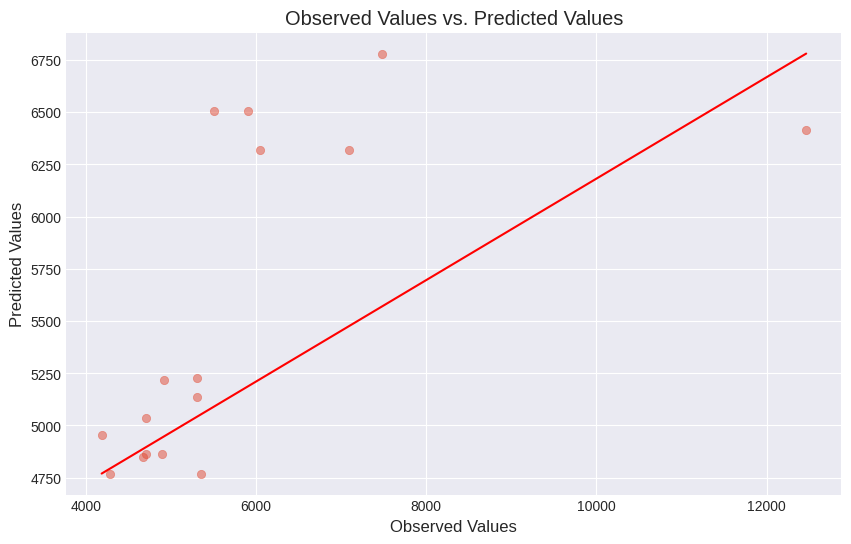

In [51]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Observed Values vs. Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_pred), max(y_pred)], color='red') 
plt.grid(True)
plt.show()

In this test context, an R² result means that 32.2% of the variance in the dependent variable can be explained by the model generated. In other words, this means that a lot of the variance in the target variable cannot be explained, so that more of the necessary features need to be included.
Thus, an RMSE of 1593.33 shows that, on average, the model's predictions deviate by around 1593.33 units from the real value.

**But what if we developed the model without the LOCAL regressor?**


In [52]:
df_ready = df_x[['TEMPOCASA', 'SALARIO_MENSAL']].copy(deep=True)

In [53]:
X = df_ready['TEMPOCASA']
y = df_ready['SALARIO_MENSAL']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
#Skilearn expects the input data to be 2d dimensional, even if it is only a single-variable format (target or feature).
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

model = LinearRegression()
model.fit(X_train, y_train)

cv_scores = cross_val_score(model, X_train, y_train, cv=5)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'R² Score: {r2}')
print(f'RMSE Score: {rmse}')

R² Score: 0.31847248319725674
RMSE Score: 1597.929310826315


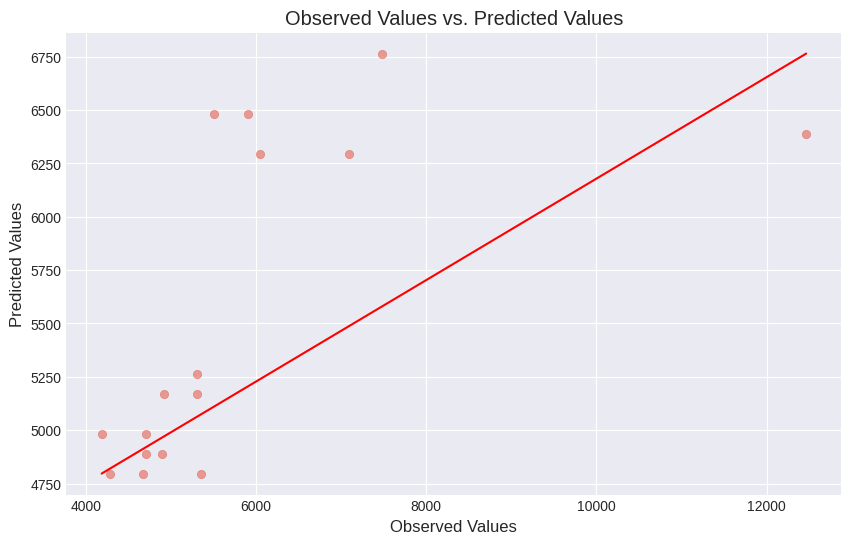

In [56]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Observed Values vs. Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_pred), max(y_pred)], color='red') 
plt.grid(True)
plt.show()

Removing the LOCAL variable gives us practically the same result as before. In this sense, in order to build an optimal predictor, it is necessary to resort to other regression models originating from Machine Learning.

### Machine Learning Predict (SVR, DecisionTreeRegression, Ridge, Lasso)

In [57]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
import joblib

def test_regression_models(X_train, X_test, y_train, y_test):

    models = {
        'Regressão Linear': LinearRegression(),
        'Árvore de Decisão': DecisionTreeRegressor(),
        'Ridge': Ridge(),
        'Lasso': Lasso(),
        'SVR': SVR()
    }

    results = {}

    for name, model in models.items():
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        results[name] = cv_scores.mean()

    best_model_name = max(results, key=results.get)
    best_model = models[best_model_name]
    best_model.fit(X_train, y_train)

    y_pred = best_model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('Observed Values')
    plt.ylabel('Predicted Values')
    plt.title('Observed Values vs. Predicted Values')
    plt.plot([min(y_test), max(y_test)], [min(y_pred), max(y_pred)], color='red') 
    plt.grid(True)
    plt.show()

    filename = f'best_model_{best_model_name}.joblib'
    joblib.dump(best_model, filename)

    return best_model_name, r2, rmse

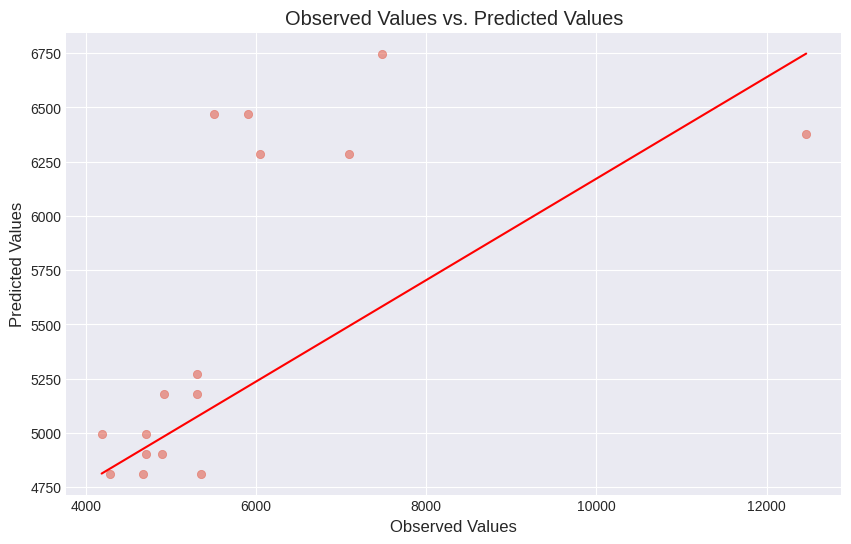

The Best Model: Ridge
R² Score: 0.3158277043903883
RMSE Score: 1601.0268214352534


In [58]:
best_model, r2, rmse = test_regression_models(X_train, X_test, y_train, y_test)
print(f'The Best Model: {best_model}')
print(f'R² Score: {r2}')
print(f'RMSE Score: {rmse}')

In [59]:
%reset -f

**General Conclusion**

- The policy of reducing inequality between employees, along with geographical inequality, was successful. The linear regression model demonstrated that the nominal categorical variable 'LOCAL' is not a statistically significant regressor for explaining the variation in the 'SALARIO_MENSAL' variable

- The Linear Regression model is of a simple type and, according to this database, has only one relevant regressor, which is 'TEMPOCASA' (years of work experience)

- The model estimated by Ordinary Least Squares is not sufficient for making predictions, even when using advanced Machine Learning regression models such as Decision Tree Regression, SVM Regression, Ridge Regression, and Lasso Regression

- What hinders more in-depth modeling and the ability to produce a regression model capable of making consistent predictions is the need to expand the scope of the database (increasing the diversity of features) and its number of observations
